# 1.8f: Three-Population Spatial Visualization

This notebook visualizes the spatial relationship between cluster, halo, and bulk tokens.

## The Hypothesis

**Jeffery's prediction:** The 1,423 unreachable-but-not-cluster tokens form a **diffuse halo** around the tight cluster core.

**Mechanism:**
- All unreachable tokens start near a common initialization point
- Early in training, uniform gradients (from uniform logits at t=1) create stochastic kicks
- In bfloat16, these kicks cause random walks between quantization cells
- Most tokens stay frozen → form tight cluster
- Some tokens get lucky kicks → escape core but stay in orbit (halo)
- Tokens with differential gradients → escape completely (bulk)

## Method

Following 1.6f's approach:
1. Compute spherical coordinates from cluster centroid
2. **Filter to volume** of interest (near cluster)
3. Color-code by population: cluster (red), halo (orange), bulk (blue)
4. Use **inverse-square apparent size scaling** (closer = bigger)
5. Create Mollweide and polar visualizations

If the hypothesis is correct, we should see:
1. Red cluster at smallest radii (tight core)
2. Orange halo at intermediate radii (diffuse orbit)
3. Blue bulk at large radii (escaped population)

## Parameters

In [292]:
# Model
MODEL_NAME = "Qwen3-4B-Instruct-2507"

# Spherical coordinate system (from cluster centroid)
NORTH_PC = 2
MERIDIAN_PC = 1
EQUINOX_PC = 3

# Volume filter (focus on region near cluster)
R_MIN = 0.0
R_MAX = 0.1
Z_MIN = -0.023
# Z_MIN = -1.0
Z_MAX = 0.038
# Z_MAX = 1.0

# Point size scaling (inverse square)
BASE_SIZE = 500  # Maximum size (for closest tokens)
EPSILON = 0.05   # Offset for inverse square to prevent division by zero

# Colors and transparency
CLUSTER_COLOR = 'red'
HALO_COLOR = 'orange'
BULK_COLOR = 'steelblue'

CLUSTER_ALPHA = 0.2
HALO_ALPHA = 0.5
BULK_ALPHA = 0.2

# Visualization
FIGSIZE = (16, 8)
DPI = 200

## Imports

In [293]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path

## Device Detection

In [294]:
# Detect available device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Data

In [295]:
# Load W (full vocabulary)
tensor_path = Path(f"../tensors/{MODEL_NAME}/W.safetensors")
W_bf16 = load_file(tensor_path)["W"]
W = W_bf16.to(torch.float32).to(device)
N, d = W.shape

print(f"Loaded W: {W.shape}")
print(f"  {N:,} tokens in {d:,} dimensions")

Loaded W: torch.Size([151936, 2560])
  151,936 tokens in 2,560 dimensions


In [296]:
# Load cluster-centric reference frame
ref_path = Path(f"../tensors/{MODEL_NAME}/1.6a_cluster_reference_frame.safetensors")
ref_data = load_file(ref_path)
cluster_centroid = ref_data['cluster_centroid'].to(device)
eigenvectors = ref_data['W_eigenvectors'].to(device)

print(f"\nLoaded reference frame:")
print(f"  Cluster centroid: {cluster_centroid.shape}")
print(f"  Centroid norm: {torch.linalg.vector_norm(cluster_centroid).item():.6f}")
print(f"  PCA eigenvectors: {eigenvectors.shape}")


Loaded reference frame:
  Cluster centroid: torch.Size([2560])
  Centroid norm: 0.370917
  PCA eigenvectors: torch.Size([2560, 2560])


In [297]:
# Load population masks from 1.8e
pop_path = Path(f"../tensors/{MODEL_NAME}/1.8e_unreachable_tokens.safetensors")
pop_data = load_file(pop_path)

cluster_mask = pop_data['cluster_mask']
halo_mask = pop_data['halo_mask']
unreachable_mask = pop_data['unreachable_mask']

# Bulk = everything NOT unreachable
bulk_mask = ~unreachable_mask

print(f"\nLoaded population masks:")
print(f"  Cluster: {cluster_mask.sum().item():,} tokens")
print(f"  Halo: {halo_mask.sum().item():,} tokens")
print(f"  Bulk: {bulk_mask.sum().item():,} tokens")


Loaded population masks:
  Cluster: 2,212 tokens
  Halo: 1,423 tokens
  Bulk: 148,579 tokens


## Define Spherical Basis

In [298]:
def get_pc_vector(pcs, index):
    """Get PC vector by index, with sign flip for negative indices."""
    pc_num = abs(index) - 1
    vector = pcs[:, pc_num].clone()
    if index < 0:
        vector = -vector
    return vector

north = get_pc_vector(eigenvectors, NORTH_PC)
meridian = get_pc_vector(eigenvectors, MERIDIAN_PC)
equinox = get_pc_vector(eigenvectors, EQUINOX_PC)

print(f"\nSpherical basis defined:")
print(f"  North: PC{NORTH_PC}")
print(f"  Meridian: PC{MERIDIAN_PC}")
print(f"  Equinox: PC{EQUINOX_PC}")


Spherical basis defined:
  North: PC2
  Meridian: PC1
  Equinox: PC3


## Compute Spherical Coordinates from Cluster Centroid

In [299]:
print("\nComputing spherical coordinates for ALL tokens from cluster centroid...\n")

# Translate to cluster-centric frame
W_centered = W - cluster_centroid

# Project onto basis
x = W_centered @ meridian
y = W_centered @ equinox
z = W_centered @ north

# Spherical coordinates
r = torch.sqrt(x**2 + y**2 + z**2)
lat_rad = torch.asin(torch.clamp(z / r, -1, 1))
lat_deg = torch.rad2deg(lat_rad)
lon_rad = torch.atan2(y, x)
lon_deg = torch.rad2deg(lon_rad)

print(f"✓ Spherical coordinates computed for all {N:,} tokens")
print(f"\nRadial distance statistics (full dataset):")
print(f"  Min: {r.min().item():.6f}")
print(f"  Max: {r.max().item():.6f}")
print(f"  Mean: {r.mean().item():.6f}")
print(f"  Median: {r.median().item():.6f}")


Computing spherical coordinates for ALL tokens from cluster centroid...

✓ Spherical coordinates computed for all 151,936 tokens

Radial distance statistics (full dataset):
  Min: 0.000000
  Max: 1.122656
  Mean: 0.162215
  Median: 0.159331


## Filter to Target Volume

In [300]:
print(f"\nFiltering to volume: r ∈ [{R_MIN}, {R_MAX}], z ∈ [{Z_MIN}, {Z_MAX}]\n")

# Apply volume filters
volume_mask = (r >= R_MIN) & (r <= R_MAX) & (z >= Z_MIN) & (z <= Z_MAX)
n_filtered = volume_mask.sum().item()

# Extract filtered coordinates
r_filtered = r[volume_mask]
lat_deg_filtered = lat_deg[volume_mask]
lon_deg_filtered = lon_deg[volume_mask]
z_filtered = z[volume_mask]

# Filter population masks to match volume
cluster_mask_filtered = cluster_mask[volume_mask.to('cpu')]
halo_mask_filtered = halo_mask[volume_mask.to('cpu')]
bulk_mask_filtered = bulk_mask[volume_mask.to('cpu')]

print(f"✓ Filtered to {n_filtered:,} tokens")
print(f"  ({100 * n_filtered / N:.3f}% of vocabulary)")
print(f"\nFiltered dataset statistics:")
print(f"  r: [{r_filtered.min().item():.6f}, {r_filtered.max().item():.6f}]")
print(f"  z: [{z_filtered.min().item():.6f}, {z_filtered.max().item():.6f}]")
print(f"\nPopulation breakdown in filtered volume:")
print(f"  Cluster: {cluster_mask_filtered.sum().item():,} tokens")
print(f"  Halo: {halo_mask_filtered.sum().item():,} tokens")
print(f"  Bulk: {bulk_mask_filtered.sum().item():,} tokens")


Filtering to volume: r ∈ [0.0, 0.1], z ∈ [-0.023, 0.038]

✓ Filtered to 9,527 tokens
  (6.270% of vocabulary)

Filtered dataset statistics:
  r: [0.000000, 0.099988]
  z: [-0.022967, 0.037981]

Population breakdown in filtered volume:
  Cluster: 2,212 tokens
  Halo: 237 tokens
  Bulk: 7,356 tokens


## Compute Point Sizes (Inverse Square)

In [301]:
print("\nComputing point sizes (inverse square scaling)...\n")

# Convert to numpy
r_np = r_filtered.cpu().numpy()
lat_np = lat_deg_filtered.cpu().numpy()
lon_np = lon_deg_filtered.cpu().numpy()

# Inverse square scaling: close = MUCH bigger, far = much smaller
r_max = r_np.max()
r_min = r_np.min()

# Normalize distances to [0, 1] range
r_normalized = (r_np - r_min) / (r_max - r_min + 1e-10)  # Add epsilon to avoid division by zero

# Inverse square with offset to prevent division by zero
sizes = BASE_SIZE * (1 / (r_normalized + EPSILON))**2

# Rescale to reasonable range
sizes = sizes / sizes.max() * BASE_SIZE

print(f"✓ Point sizes computed")
print(f"  Size range: [{sizes.min():.2f}, {sizes.max():.2f}]")
print(f"  Mean size: {sizes.mean():.2f}")


Computing point sizes (inverse square scaling)...

✓ Point sizes computed
  Size range: [1.13, 500.00]
  Mean size: 126.81


## Mollweide Sky Map: Three Populations


Creating Mollweide sky map with three populations...



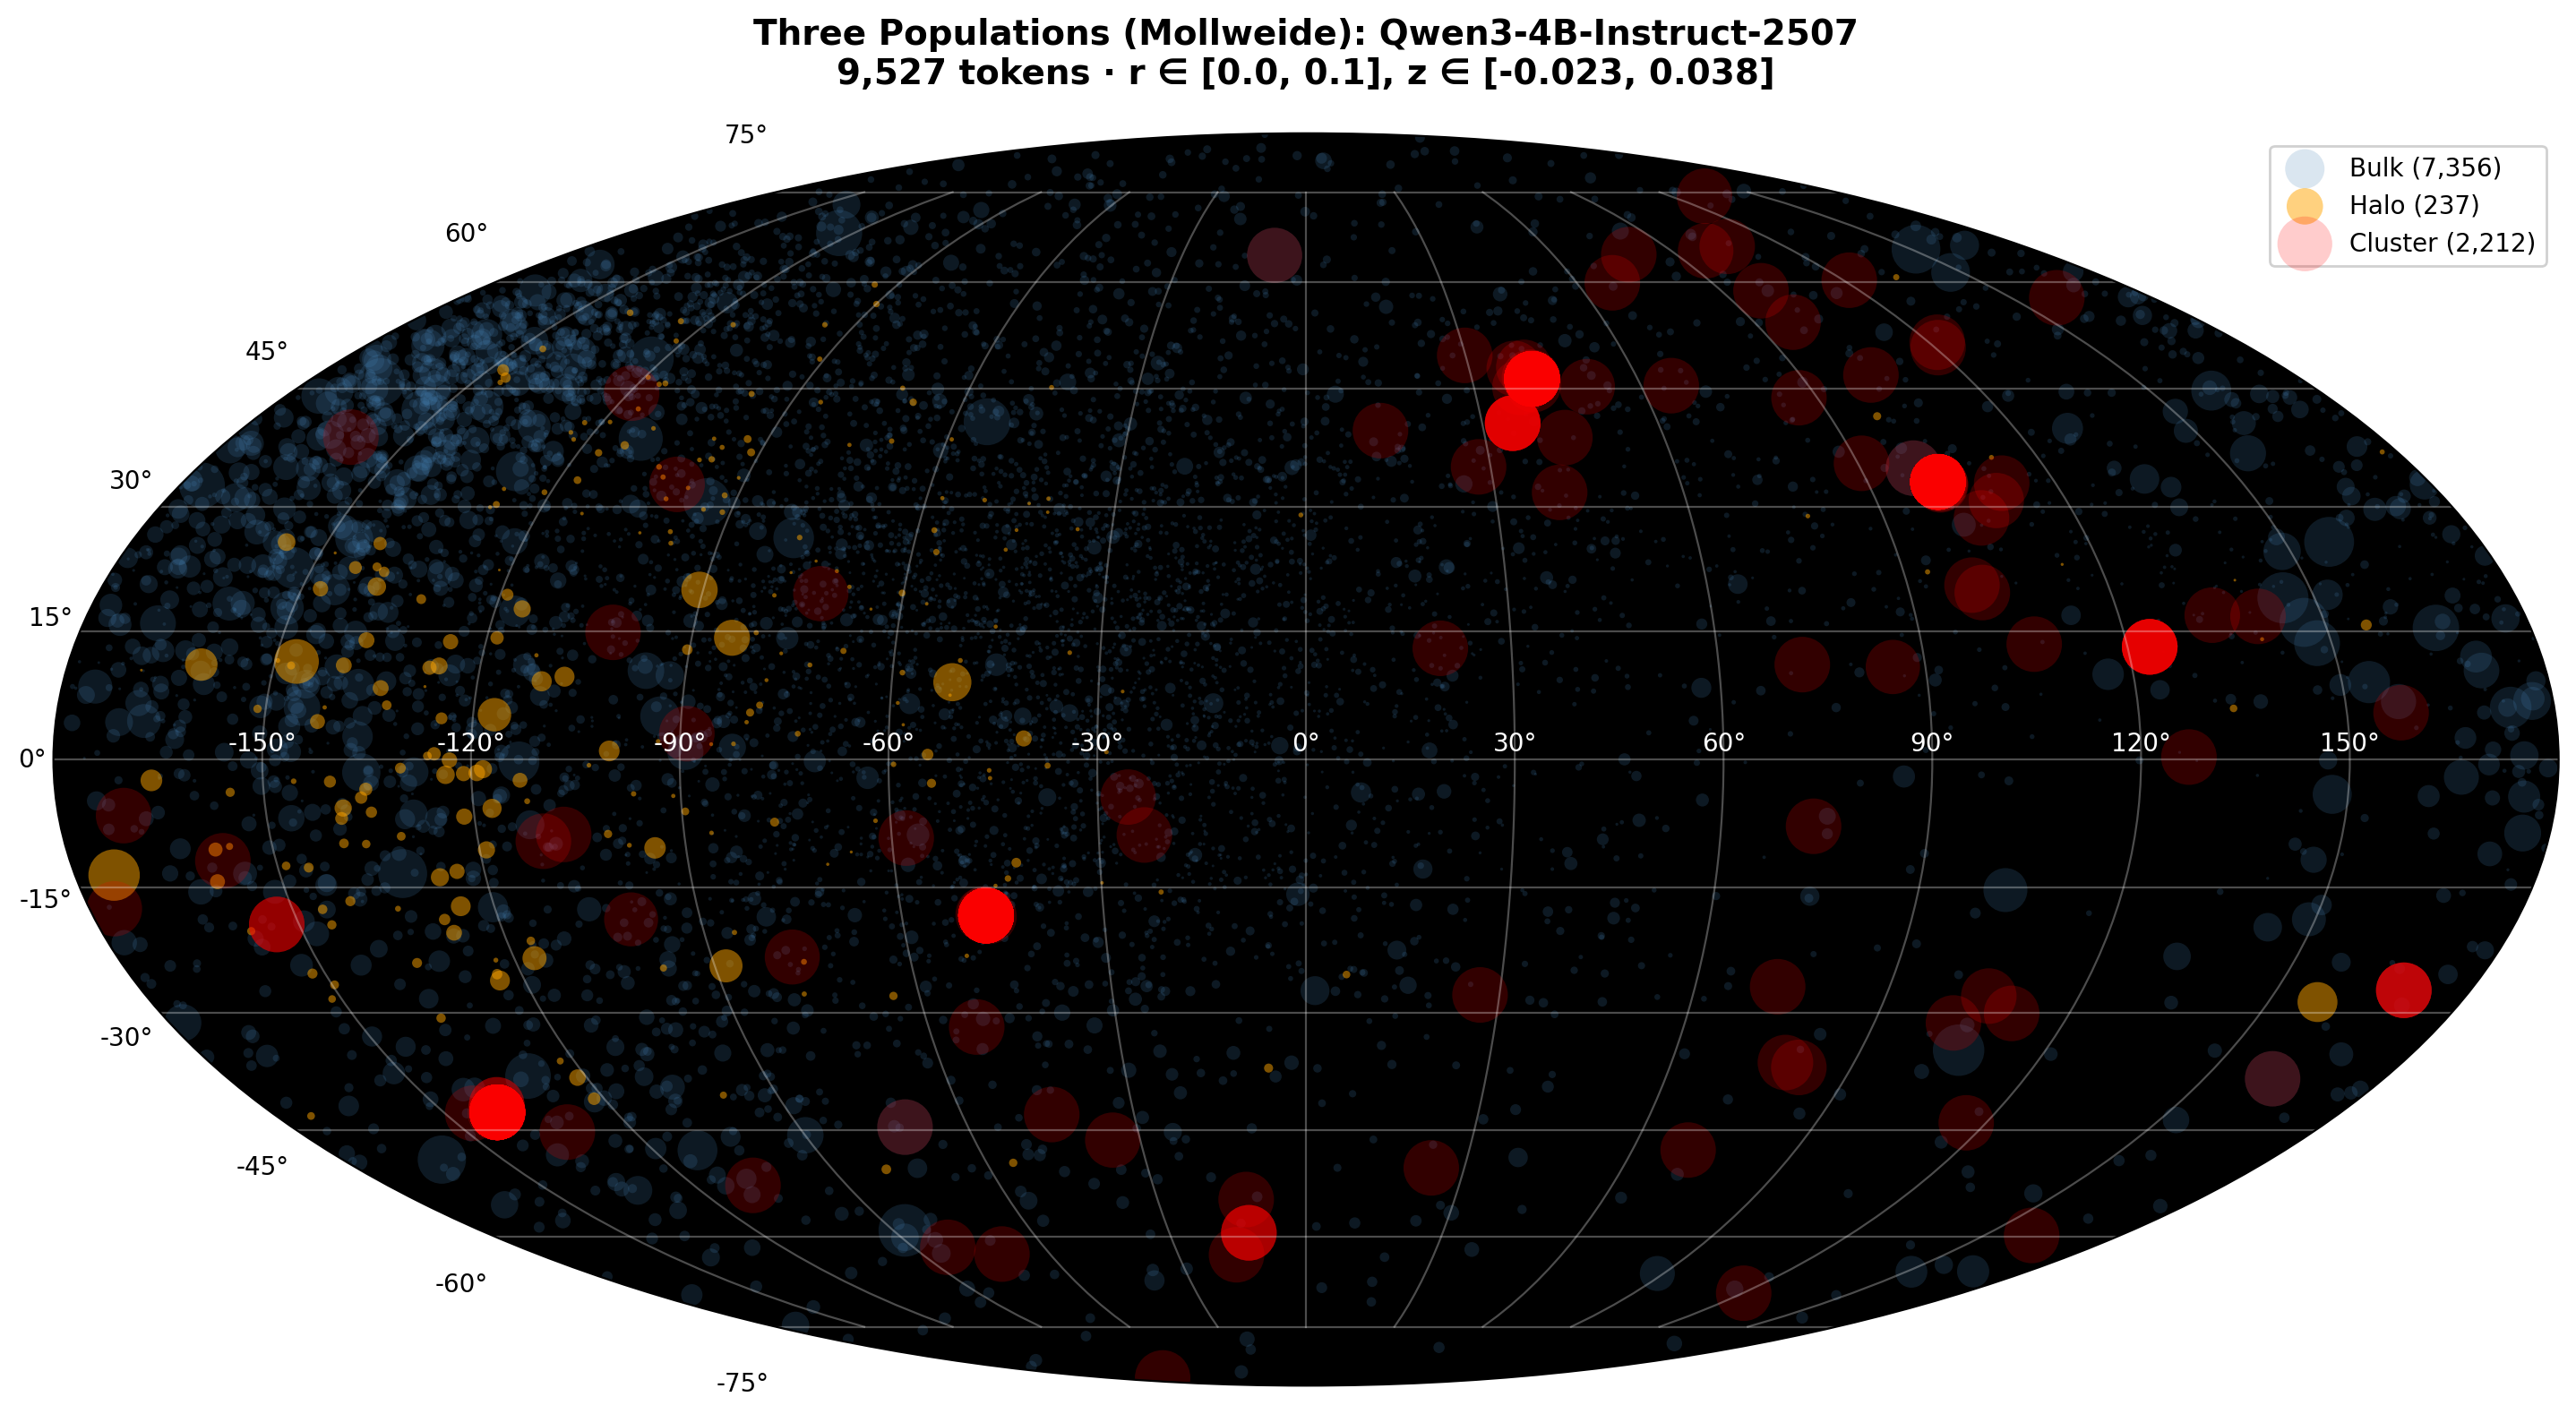

✓ Mollweide sky map complete


In [302]:
print(f"\nCreating Mollweide sky map with three populations...\n")

# Convert to radians for plotting
lon_rad_np = np.deg2rad(lon_np)
lat_rad_np = np.deg2rad(lat_np)

# Convert population masks to numpy
cluster_mask_np = cluster_mask_filtered.cpu().numpy()
halo_mask_np = halo_mask_filtered.cpu().numpy()
bulk_mask_np = bulk_mask_filtered.cpu().numpy()

# Create figure
fig = plt.figure(figsize=FIGSIZE, dpi=DPI)
ax = fig.add_subplot(111, projection='mollweide')
ax.set_facecolor('black')

# Plot in order: bulk (background), halo (middle), cluster (foreground)
# This ensures cluster is most visible

# Bulk (blue, varies by distance)
if bulk_mask_np.sum() > 0:
    ax.scatter(lon_rad_np[bulk_mask_np], lat_rad_np[bulk_mask_np],
               s=sizes[bulk_mask_np],
               alpha=BULK_ALPHA,
               c=BULK_COLOR,
               edgecolors='none',
               rasterized=True,
               label=f'Bulk ({bulk_mask_np.sum():,})')

# Halo (orange, varies by distance)
if halo_mask_np.sum() > 0:
    ax.scatter(lon_rad_np[halo_mask_np], lat_rad_np[halo_mask_np],
               s=sizes[halo_mask_np],
               alpha=HALO_ALPHA,
               c=HALO_COLOR,
               edgecolors='none',
               rasterized=True,
               label=f'Halo ({halo_mask_np.sum():,})')

# Cluster (red, varies by distance)
if cluster_mask_np.sum() > 0:
    ax.scatter(lon_rad_np[cluster_mask_np], lat_rad_np[cluster_mask_np],
               s=sizes[cluster_mask_np],
               alpha=CLUSTER_ALPHA,
               c=CLUSTER_COLOR,
               edgecolors='none',
               rasterized=True,
               label=f'Cluster ({cluster_mask_np.sum():,})')

# Formatting
ax.grid(True, alpha=0.3, color='white')
ax.legend(loc='upper right', framealpha=0.9, fontsize=10)
ax.set_title(f'Three Populations (Mollweide): {MODEL_NAME}\n' +
             f'{n_filtered:,} tokens · r ∈ [{R_MIN}, {R_MAX}], z ∈ [{Z_MIN}, {Z_MAX}]',
             color='black', pad=20, fontsize=14, fontweight='bold')

# Set tick colors
for label in ax.get_xticklabels():
    label.set_color('white')
for label in ax.get_yticklabels():
    label.set_color('black')

plt.tight_layout()
plt.show()

print("✓ Mollweide sky map complete")

## Polar (Equatorial) Sky Map: Three Populations


Creating polar equatorial sky map...



/var/folders/k5/44vd1ct56xj4y9h7x213kvjr0000gn/T/ipykernel_85045/2168862321.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{int(d)}°' for d in tick_degs])


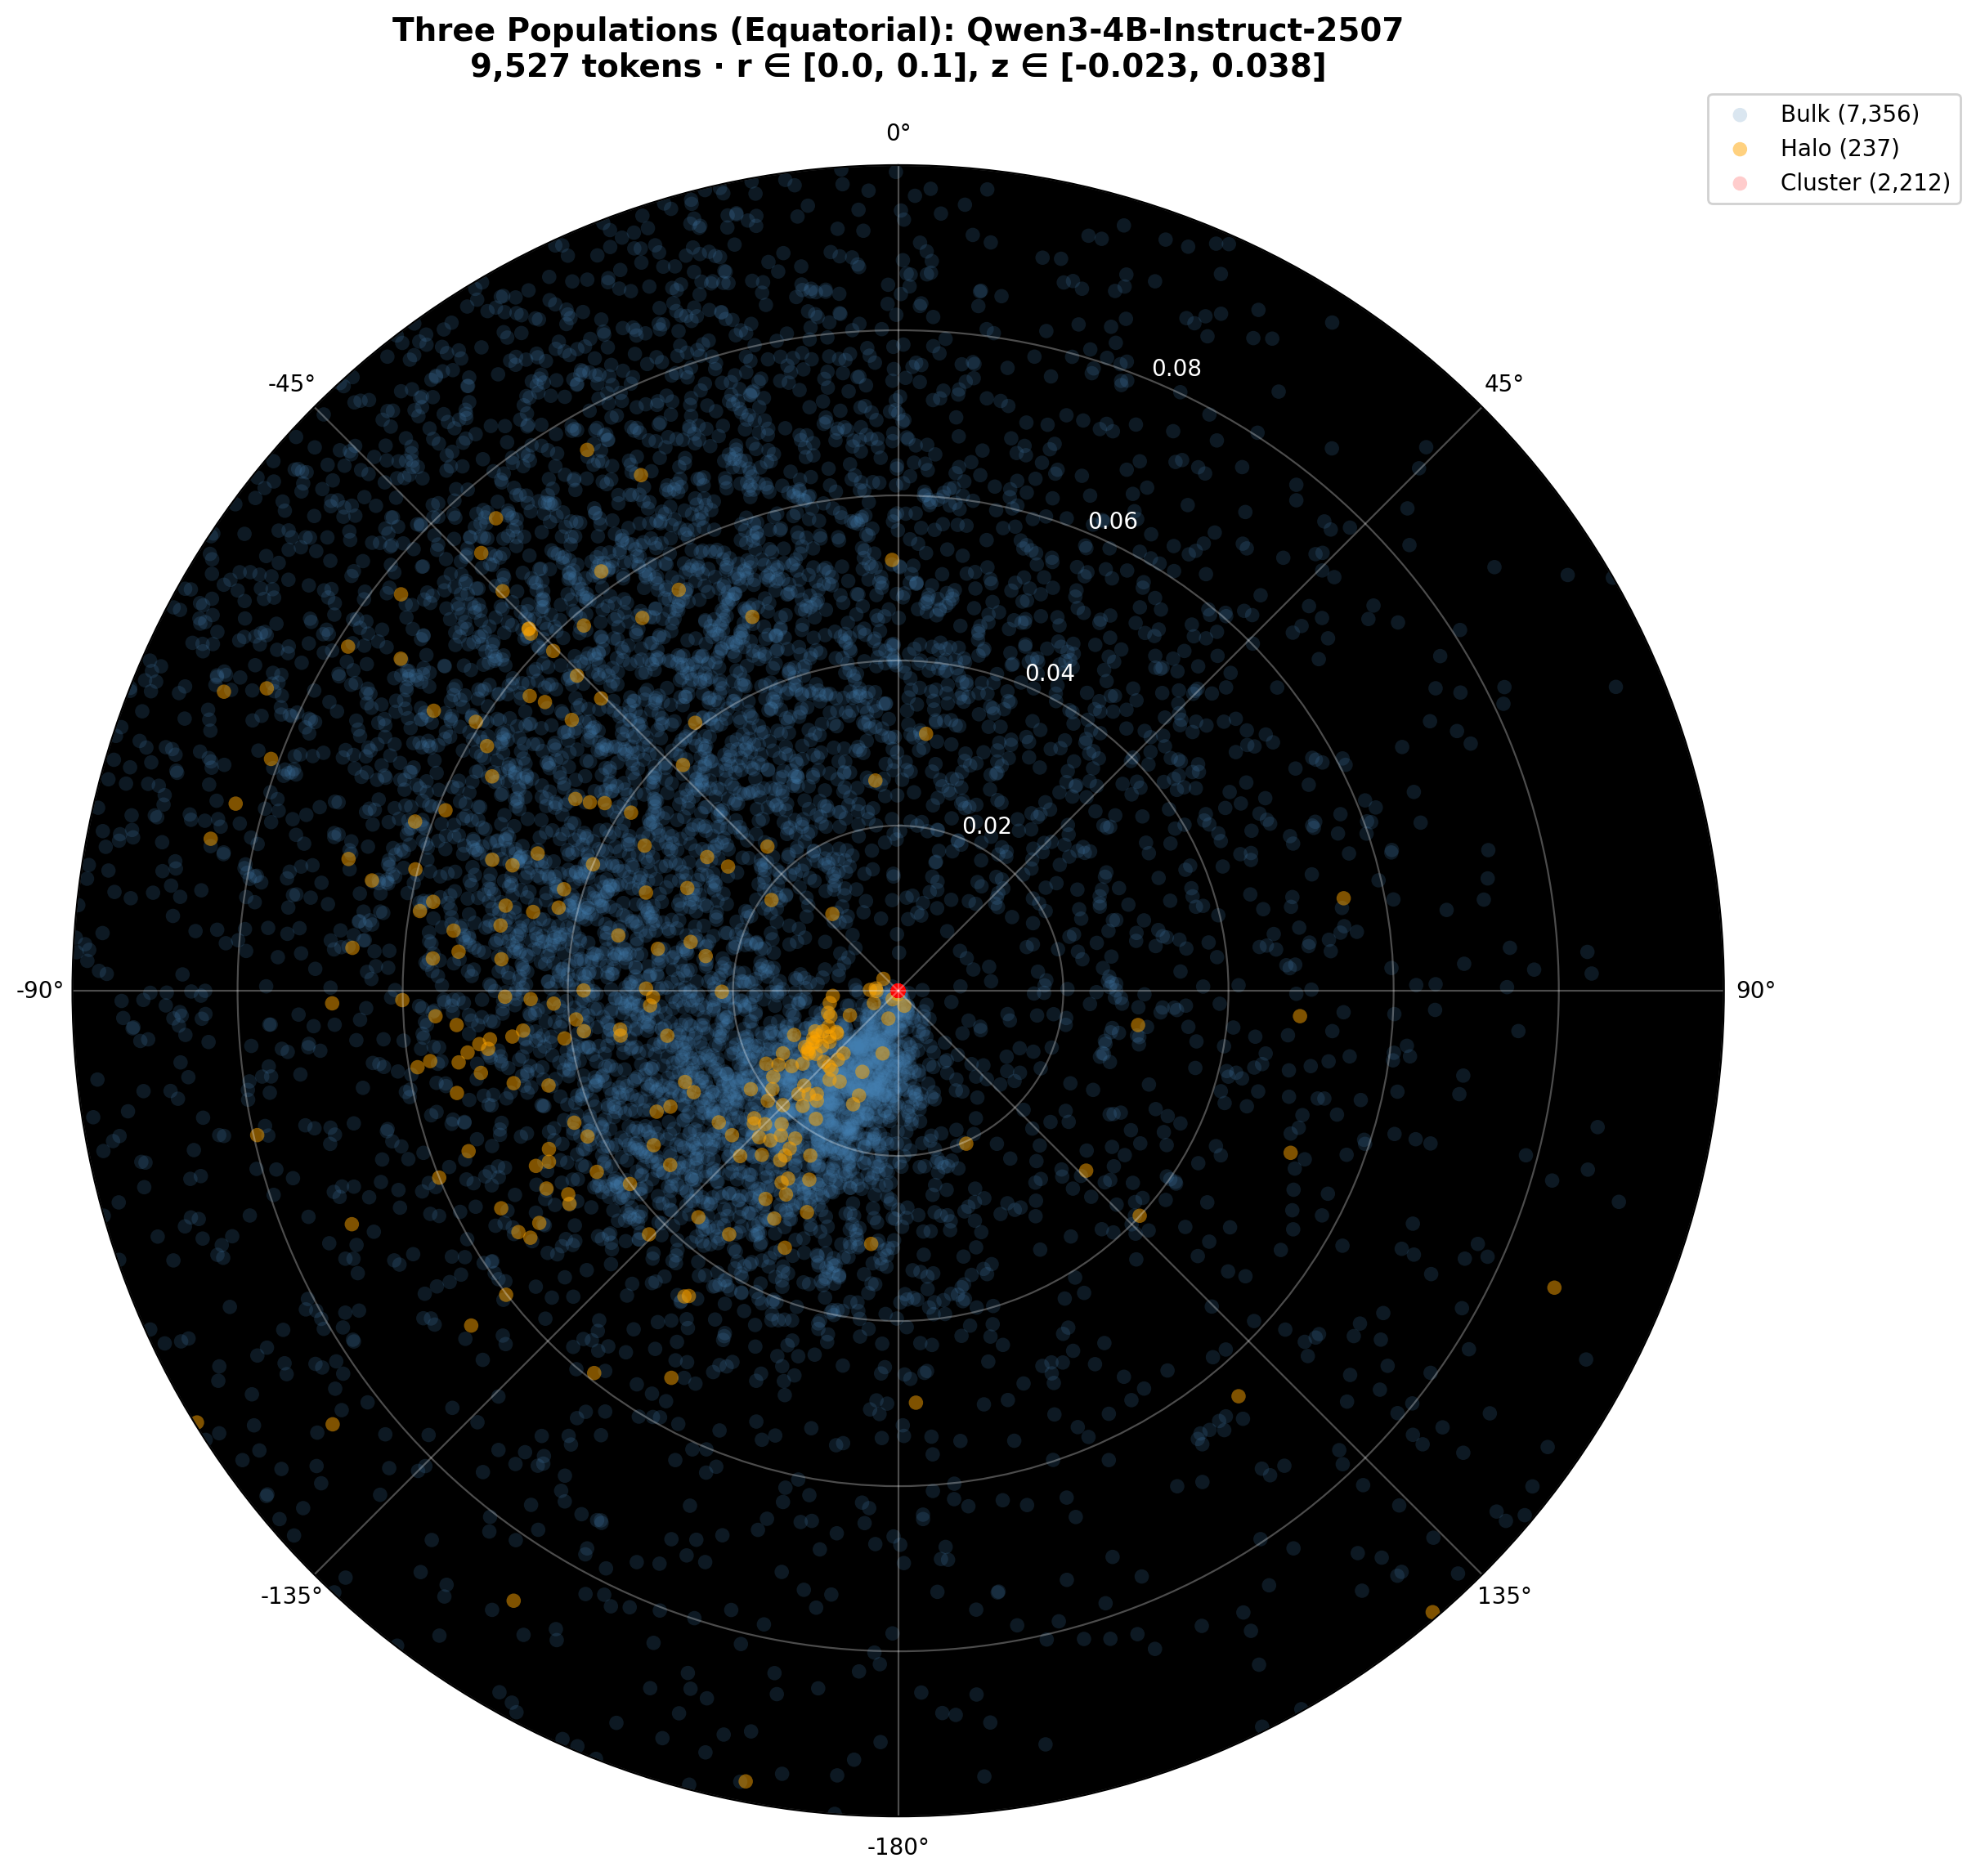

✓ Polar equatorial sky map complete


In [303]:
print(f"\nCreating polar equatorial sky map...\n")

# Create figure
fig = plt.figure(figsize=(12, 12), dpi=DPI)
ax = fig.add_subplot(111, projection='polar')
ax.set_facecolor('black')

# Fixed size for polar plot (distance already encoded in radius)
POLAR_SIZE = 40.0

# Plot in order: bulk, halo, cluster

# Bulk (blue)
if bulk_mask_np.sum() > 0:
    ax.scatter(lon_rad_np[bulk_mask_np], r_np[bulk_mask_np],
               s=POLAR_SIZE,
               alpha=BULK_ALPHA,
               c=BULK_COLOR,
               edgecolors='none',
               rasterized=True,
               label=f'Bulk ({bulk_mask_np.sum():,})')

# Halo (orange)
if halo_mask_np.sum() > 0:
    ax.scatter(lon_rad_np[halo_mask_np], r_np[halo_mask_np],
               s=POLAR_SIZE,
               alpha=HALO_ALPHA,
               c=HALO_COLOR,
               edgecolors='none',
               rasterized=True,
               label=f'Halo ({halo_mask_np.sum():,})')

# Cluster (red)
if cluster_mask_np.sum() > 0:
    ax.scatter(lon_rad_np[cluster_mask_np], r_np[cluster_mask_np],
               s=POLAR_SIZE,
               alpha=CLUSTER_ALPHA,
               c=CLUSTER_COLOR,
               edgecolors='none',
               rasterized=True,
               label=f'Cluster ({cluster_mask_np.sum():,})')

# Formatting
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.grid(True, alpha=0.3, color='white')
ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1.05), framealpha=0.9, fontsize=10)
ax.set_title(f'Three Populations (Equatorial): {MODEL_NAME}\n' +
             f'{n_filtered:,} tokens · r ∈ [{R_MIN}, {R_MAX}], z ∈ [{Z_MIN}, {Z_MAX}]',
             color='black', pad=20, fontsize=14, fontweight='bold')

# Get the default tick positions (in radians)
tick_locs = ax.get_xticks()

# Convert each tick from radians to degrees
tick_degs = np.rad2deg(tick_locs)

# Wrap to -180 to 180 range
tick_degs = ((tick_degs + 180) % 360) - 180

# Set the labels (but keep original positions)
ax.set_xticklabels([f'{int(d)}°' for d in tick_degs])

# Set tick colors
for label in ax.get_xticklabels():
    label.set_color('black')
for label in ax.get_yticklabels():
    label.set_color('white')

# Set radial limits to match filtered data
ax.set_rlim(bottom=R_MIN, top=R_MAX)

plt.tight_layout()
plt.show()

print("✓ Polar equatorial sky map complete")

## Observations

### If halo hypothesis is SUPPORTED:
- **Cluster (red)** appears as bright core at origin (large points = close)
- **Halo (orange)** forms diffuse cloud at intermediate distances (medium-sized points)
- **Bulk (blue)** scattered at larger distances (small points = far)
- Polar plot shows radial stratification: cluster innermost, halo middle layer, bulk outer

### If halo hypothesis is REJECTED:
- Halo tokens scattered randomly with no preferred distance from cluster
- Orange points intermingled with blue (no intermediate layer)
- Polar plot shows halo overlapping bulk radii

### Key Questions:
1. Is there a clear radial separation: cluster < halo < bulk?
2. Do halo tokens show intermediate sizes in Mollweide (intermediate distances)?
3. Are halo tokens directionally correlated with cluster (same angular region)?
4. Is there a void between inner structure (cluster + halo) and bulk?

**Expected result (if hypothesis correct):**
- Red core at center (biggest points)
- Orange shell surrounding red (medium points)
- Blue scattered far away (smallest points)
- Clear three-tier structure in both views